In [1]:
import os
import glob
import json

from PIL import Image

import numpy as np
import pandas as pd


class Structure(object):
    """Structure which contains the images, masks and labels."""

    def __init__(self, label_path, image_path, mask_path):
        """Init.

        :param label_path: (str) path of json file
        :param image_path: (str) path of images
        :param mask_path: (str) path of masks
        """
        self.label_path = label_path
        self.image_path = image_path
        self.mask_path = mask_path
        self.width = 512
        self.height = 512
        self.base_path_masks = str()
        self.base_path_images = str()
        self.data = dict()
        self.labels_df = pd.DataFrame()

    @staticmethod
    def find_all_files(path):
        """Find all the files in a directory.

        :param path: (str) path of the images or masks
        :return: (list) all paths
        """
        return glob.glob(os.path.join(path, "*"))

    @staticmethod
    def read_json(path):
        """Read json file.

        :param path: (str) path of the json file
        :return: (dict) labels of each images
        """
        with open(path, 'r') as f:
            labels = json.load(f)

        return labels

    @staticmethod
    def base_path(path):
        """Find the basic path for the masks & images

        :param path: (str) path of an image or a mask
        :return: (str) base path
        """
        return "/".join(path.split("/")[:-1]) + "/{}." + path.split(".")[-1]

    @staticmethod
    def find_images_id(paths):
        """Find the images & masks id

        :param paths: (list) all paths
        :return: (list) images id
        """
        return [path.split("/")[-1].split(".")[0] for path in paths]

    def find_images_with_masks(self, images_id, masks_id):
        """Find all the images which contains a masks.

        :param images_id: (list) images_id
        :param masks_id: (list) masks_id
        :return: (tuple) ids, masks_paths, images_paths
        """
        ids = set(images_id).intersection(set(masks_id))
        masks_paths = [self.base_path_masks.format(path) for path in ids]
        images_paths = [self.base_path_images.format(path) for path in ids]

        return ids, masks_paths, images_paths

    @staticmethod
    def read_image(path, width, height, mode="RGB"):
        """Read image as a numpy array.

        :param path: (str) path of the image
        :param width: (int) new width size
        :param height: (int) new height size
        :param mode: (str) 'RGB' or 'L' image in color or gray
        :return: (np.array) image as np.array
        """
        image = Image.open(path)
        image = image.resize([width, height], Image.BILINEAR)

        return np.array(image.convert(mode))

    def read_masks_images_by_id(self, ids, masks_path, images_path):
        """Read the masks and images as array.

        :param ids: (set) ids of the images
        :param masks_path: (list) all masks paths
        :param images_path: (list) all images paths
        :return: (dict) {'id': {'mask': np.array, 'image': np.array'}}
        """
        ids = sorted(ids)
        masks_path = sorted(masks_path)
        images_path = sorted(images_path)
        data = dict()
        for i in range(len(ids)):
            data[ids[i]] = {
                "mask": self.read_image(masks_path[i], self.height, self.width),
                "image": self.read_image(images_path[i], self.height, self.width)
            }

        return data

    @staticmethod
    def transform_labels_to_df(labels, ids):
        """Transform the json into dataframe.

        :param labels: (dict) labels data
        :param ids: (set) ids of the images
        :return: (pd.DataFrame) [bbox, iscrowd, filename, isthing, name, supercategory]
        """
        df_labels = pd.DataFrame()
        for label in labels["annotations"]:
            filename = label["file_name"].split(".")[0]
            if filename in ids:
                df = pd.DataFrame(label["segments_info"])
                df["filename"] = filename
                df_labels = pd.concat([df_labels, df])

        labels_df = pd.merge(df_labels, pd.DataFrame(labels["categories"]), left_on="category_id", right_on="id")
        labels_df = labels_df.drop(["area", "category_id", "id_x", "id_y"], axis=1)

        return labels_df

    def prepare(self):
        """Prepare the dataset.

        :return: tbd
        """
        masks_path = self.find_all_files(self.mask_path)
        images_path = self.find_all_files(self.image_path)
        labels = self.read_json(self.label_path)
        masks_id = self.find_images_id(masks_path)
        images_id = self.find_images_id(images_path)

        self.base_path_masks = self.base_path(masks_path[0])
        self.base_path_images = self.base_path(images_path[0])
        ids, masks_path, images_path = self.find_images_with_masks(images_id, masks_id)
        self.data = self.read_masks_images_by_id(ids, masks_path, images_path)
        self.labels_df = self.transform_labels_to_df(labels, ids)


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
struct = Structure(label_path="../data/raw/maskrcnn/labels.json", image_path="../data/raw/maskrcnn/images", mask_path="../data/raw/maskrcnn/masks")

In [4]:
struct.prepare()

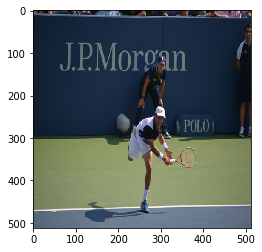

In [5]:
plt.imshow(struct.data["000000000885"]["image"])

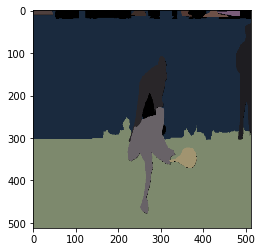

In [6]:
plt.imshow(struct.data["000000000885"]["mask"])

In [9]:
struct.labels_df.head()

,bbox,iscrowd,filename,isthing,name,supercategory
0,"[596, 26, 43, 227]",0,000000000885,1,person,person
1,"[288, 0, 44, 12]",0,000000000885,1,person,person
2,"[277, 190, 140, 208]",0,000000000885,1,person,person
3,"[1, 1, 58, 8]",0,000000000885,1,person,person
4,"[500, 1, 74, 13]",0,000000000885,1,person,person
